<a href="https://www.kaggle.com/code/habibulbasher01644/olive-leaf-image-classification?scriptVersionId=222355335" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/olive-leaf-image-dataset'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt

# Data augmentation

In [3]:
# Define image size
img_height, img_width = 128, 128
batch_size = 32

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=50,    
    zoom_range=[0.5, 1.0],         # Zoom augmentation
    brightness_range=[0.2, 1.0],   # Brightness augmentation
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [4]:

# Load images from directory
train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/olive-leaf-image-dataset/dataset/train',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle = True
)

test_generator = test_datagen.flow_from_directory(
    '/kaggle/input/olive-leaf-image-dataset/dataset/test',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle = False
)

# Get class indices
print(train_generator.class_indices)

Found 2720 images belonging to 3 classes.
Found 680 images belonging to 3 classes.
{'Healthy': 0, 'aculus_olearius': 1, 'olive_peacock_spot': 2}


# Approach 1: Build a Custom CNN Model

In [5]:
# Define a simple CNN model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

# Define a simple CNN model
model = Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(256, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),  # Prevent overfitting
    layers.Dense(3, activation='softmax')  # 3 classes
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,179,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,568,579 (5.98 MB)

 Trainable params: 1,568,579 (5.98 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [8]:

# Train the model
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=test_generator
)

# Save model
# model.save("olive_cnn_model.h5")

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


85/85 ━━━━━━━━━━━━━━━━━━━━ 47s 433ms/step - accuracy: 0.4108 - loss: 1.0826 - val_accuracy: 0.3824 - val_loss: 1.0516
Epoch 2/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 22s 241ms/step - accuracy: 0.5331 - loss: 0.9046 - val_accuracy: 0.5250 - val_loss: 0.9603
Epoch 3/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 21s 231ms/step - accuracy: 0.6173 - loss: 0.7889 - val_accuracy: 0.5324 - val_loss: 0.9010
Epoch 4/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 21s 230ms/step - accuracy: 0.6460 - loss: 0.7427 - val_accuracy: 0.5412 - val_loss: 0.8863
Epoch 5/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 21s 234ms/step - accuracy: 0.6724 - loss: 0.7197 - val_accuracy: 0.5574 - val_loss: 0.9159
Epoch 6/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 21s 230ms/step - accuracy: 0.6924 - loss: 0.6798 - val_accuracy: 0.5897 - val_loss: 0.8343
Epoch 7/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 21s 231ms/step - accuracy: 0.7116 - loss: 0.6387 - val_accuracy: 0.6029 - val_loss: 0.7989
Epoch 8/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 21s 232ms/step - accuracy: 0.7189 - loss: 0.6329 - val_accuracy: 0.538

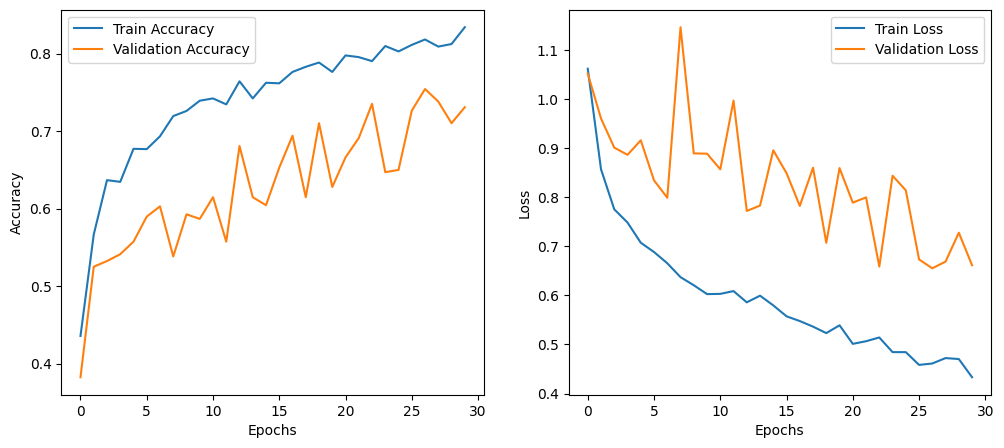

In [9]:
# Plot accuracy & loss
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [10]:
# Evaluate on test data
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.6876 - loss: 0.7602
Test Accuracy: 0.7309


In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
# Get class labels from the generator
class_labels = list(test_generator.class_indices.keys())  # ['healthy', 'aculus_olearius', 'olive_peacock_spot']
print("Class Labels:", class_labels)
# Predict the test set
steps = test_generator.samples // test_generator.batch_size
y_pred = model.predict(test_generator, steps=steps, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert softmax outputs to class indices

# Get actual labels
y_true = test_generator.classes[:len(y_pred_classes)]

Class Labels: ['Healthy', 'aculus_olearius', 'olive_peacock_spot']
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step


In [12]:

# Generate and print confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:\n", conf_matrix)

# Generate and print classification report
report = classification_report(y_true, y_pred_classes, target_names=class_labels)
print("Classification Report:\n", report)


Confusion Matrix:
 [[134  60  26]
 [ 23 143  34]
 [  5  35 212]]
Classification Report:
                     precision    recall  f1-score   support

           Healthy       0.83      0.61      0.70       220
   aculus_olearius       0.60      0.71      0.65       200
olive_peacock_spot       0.78      0.84      0.81       252

          accuracy                           0.73       672
         macro avg       0.74      0.72      0.72       672
      weighted avg       0.74      0.73      0.73       672



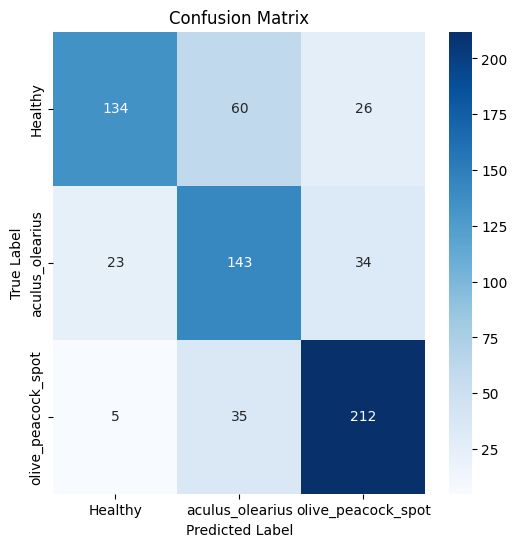

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot confusion matrix
plt.figure(figsize=(6,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# Approach 2: Using four Pre-trained CNN Model

# Data Augmentation
## ImageDataGenerator
    
* rescale: Makes the image numbers smaller so the computer can understand.(rescale=1./255 - Makes all pixel values between 0 and 1)
* rotation_range: Spins the image around.
* width_shift_range and height_shift_range: Moves the image left/right or up/down.
* shear_range: Tilts the image.
* zoom_range: Zooms in or out.
* horizontal_flip and vertical_flip: Flips the image left/right or upside-down.
* fill_mode: Fills empty spaces when you move or tilt the image.


In [14]:
train_datagen= ImageDataGenerator(
    rescale=1.0/255,
    zoom_range=[0.5, 1.0],
    brightness_range=[0.2, 1.0],
    horizontal_flip=True,
    rotation_range=50,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
)

test_datagen = ImageDataGenerator(rescale=1./255)



# Data Loading

In [15]:

IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32


# Load images from directory
train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/olive-leaf-image-dataset/dataset/train',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle = True
)

test_generator = test_datagen.flow_from_directory(
    '/kaggle/input/olive-leaf-image-dataset/dataset/test',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle = False
)

# Get class indices
print(train_generator.class_indices)


Found 2720 images belonging to 3 classes.
Found 680 images belonging to 3 classes.
{'Healthy': 0, 'aculus_olearius': 1, 'olive_peacock_spot': 2}


# Function to Create vgg16 Model

In [16]:
def create_model_vgg16():
    # Load the VGG16 model without its top layer, with ImageNet weights
    base_model = applications.VGG16(weights='imagenet', include_top=False, 
                                    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    # Freeze the base model initially
    base_model.trainable = False
    
    # Build the new model on top of the base model
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(3, activation='softmax')
    ])
    
    # Compile the model with an initial learning rate
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = create_model_vgg16()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# Initialize 4 Pre-trained Models

In [17]:

EPOCHS_PHASE1 = 15

history_phase1 = model.fit(
    train_generator,
    epochs=EPOCHS_PHASE1,
    validation_data=test_generator,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
    ]
)


Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


85/85 ━━━━━━━━━━━━━━━━━━━━ 63s 523ms/step - accuracy: 0.3844 - loss: 1.7544 - val_accuracy: 0.4147 - val_loss: 1.5330 - learning_rate: 1.0000e-04
Epoch 2/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 42s 452ms/step - accuracy: 0.5677 - loss: 1.3756 - val_accuracy: 0.4794 - val_loss: 1.4223 - learning_rate: 1.0000e-04
Epoch 3/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 41s 445ms/step - accuracy: 0.6148 - loss: 1.2296 - val_accuracy: 0.5882 - val_loss: 1.3120 - learning_rate: 1.0000e-04
Epoch 4/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 41s 448ms/step - accuracy: 0.6115 - loss: 1.1712 - val_accuracy: 0.6441 - val_loss: 1.1969 - learning_rate: 1.0000e-04
Epoch 5/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 42s 452ms/step - accuracy: 0.6583 - loss: 1.0810 - val_accuracy: 0.5897 - val_loss: 1.1783 - learning_rate: 1.0000e-04
Epoch 6/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 41s 446ms/step - accuracy: 0.6525 - loss: 1.0755 - val_accuracy: 0.6897 - val_loss: 0.9918 - learning_rate: 1.0000e-04
Epoch 7/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 42s 452ms/step - accuracy: 0.65

In [18]:
for layer in model.layers[0].layers[-20:]:
    layer.trainable = True

# Re-compile the model with a lower learning rate for fine-tuning.
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

EPOCHS_PHASE2 = 10

history_phase2 = model.fit(
    train_generator,
    epochs=EPOCHS_PHASE2,
    validation_data=test_generator,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
    ]
)


Epoch 1/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 90s 540ms/step - accuracy: 0.7067 - loss: 0.9012 - val_accuracy: 0.7103 - val_loss: 0.9720 - learning_rate: 1.0000e-05
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 49s 531ms/step - accuracy: 0.8317 - loss: 0.6464 - val_accuracy: 0.8956 - val_loss: 0.5033 - learning_rate: 1.0000e-05
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 48s 527ms/step - accuracy: 0.8778 - loss: 0.5339 - val_accuracy: 0.8971 - val_loss: 0.5324 - learning_rate: 1.0000e-05
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 49s 530ms/step - accuracy: 0.8872 - loss: 0.5276 - val_accuracy: 0.9059 - val_loss: 0.4786 - learning_rate: 1.0000e-05
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 49s 529ms/step - accuracy: 0.9097 - loss: 0.4567 - val_accuracy: 0.8353 - val_loss: 0.6458 - learning_rate: 1.0000e-05
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 49s 531ms/step - accuracy: 0.9274 - loss: 0.4250 - val_accuracy: 0.9250 - val_loss: 0.4279 - learning_rate: 1.0000e-05
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 49s 534ms/step - acc

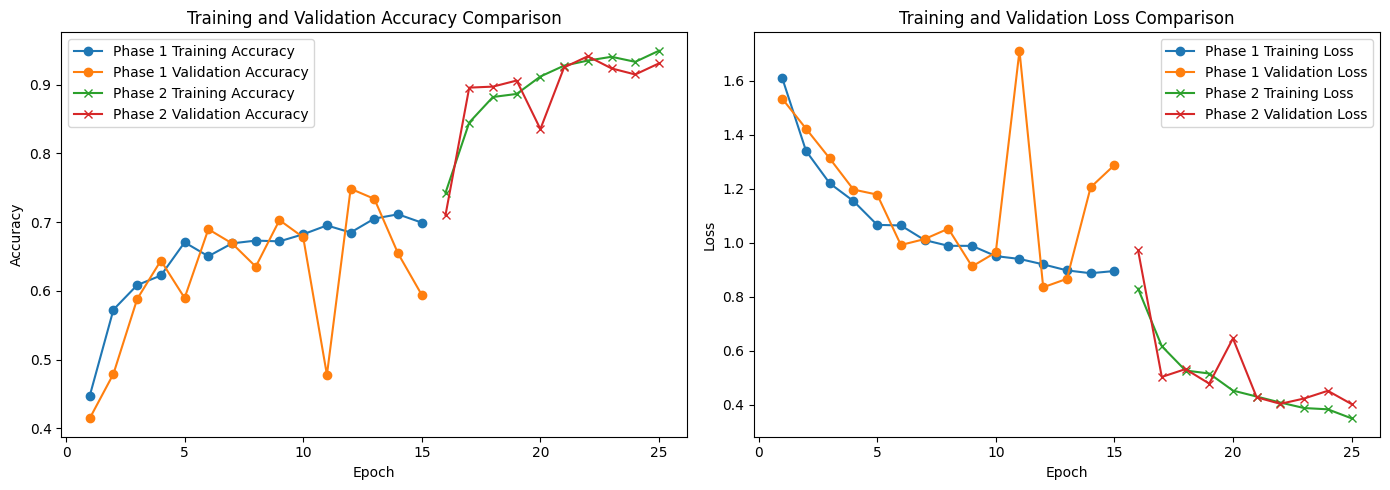

In [19]:
import matplotlib.pyplot as plt

# Retrieve metrics from Phase 1
acc_phase1 = history_phase1.history['accuracy']
val_acc_phase1 = history_phase1.history['val_accuracy']
loss_phase1 = history_phase1.history['loss']
val_loss_phase1 = history_phase1.history['val_loss']
epochs_phase1 = range(1, len(acc_phase1) + 1)

# Retrieve metrics from Phase 2
acc_phase2 = history_phase2.history['accuracy']
val_acc_phase2 = history_phase2.history['val_accuracy']
loss_phase2 = history_phase2.history['loss']
val_loss_phase2 = history_phase2.history['val_loss']
# Offset Phase 2 epochs to continue from Phase 1
start_epoch_phase2 = len(acc_phase1) + 1
epochs_phase2 = range(start_epoch_phase2, start_epoch_phase2 + len(acc_phase2))

plt.figure(figsize=(14, 5))

# Plot Accuracy Comparison
plt.subplot(1, 2, 1)
plt.plot(epochs_phase1, acc_phase1, 'o-', label='Phase 1 Training Accuracy')
plt.plot(epochs_phase1, val_acc_phase1, 'o-', label='Phase 1 Validation Accuracy')
plt.plot(epochs_phase2, acc_phase2, 'x-', label='Phase 2 Training Accuracy')
plt.plot(epochs_phase2, val_acc_phase2, 'x-', label='Phase 2 Validation Accuracy')
plt.title('Training and Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss Comparison
plt.subplot(1, 2, 2)
plt.plot(epochs_phase1, loss_phase1, 'o-', label='Phase 1 Training Loss')
plt.plot(epochs_phase1, val_loss_phase1, 'o-', label='Phase 1 Validation Loss')
plt.plot(epochs_phase2, loss_phase2, 'x-', label='Phase 2 Training Loss')
plt.plot(epochs_phase2, val_loss_phase2, 'x-', label='Phase 2 Validation Loss')
plt.title('Training and Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step
Classification Report:
                     precision    recall  f1-score   support

           Healthy       0.96      0.88      0.92       220
   aculus_olearius       0.92      0.96      0.94       200
olive_peacock_spot       0.92      0.95      0.93       260

          accuracy                           0.93       680
         macro avg       0.93      0.93      0.93       680
      weighted avg       0.93      0.93      0.93       680

Confusion Matrix:
 [[193  10  17]
 [  2 192   6]
 [  6   6 248]]


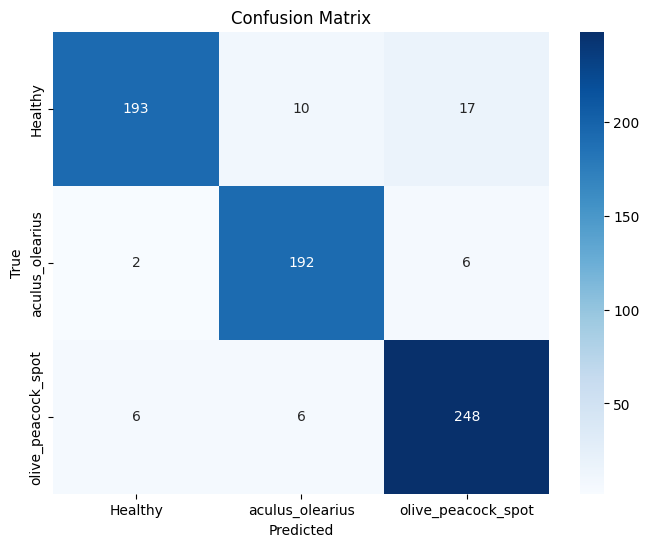

In [20]:
import numpy as np
from sklearn.metrics import classification_report

# Reset the test generator to ensure correct predictions
test_generator.reset()
predictions = model.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Generate and print the classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:\n", cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


